# Time-Series Classification: Dataset USC-HAD
_by Mikhail Karasikov_

In [1]:
import numpy as np
import pandas
import multiclass
import timeseries
import feature_extraction

dataset = timeseries.TSDataset.load_from_mat('../../data/USC-HAD/USC_HAD_dataset.mat')
print("Dataset size: %d" % len(dataset))
print("Stats:\n", pandas.DataFrame([ts.shape for ts in dataset.ts],
                                   columns=['dim', 'len']).describe()[1:].round())

Dataset size: 840
Stats:
       dim    len
mean    6   3347
std     0   1978
min     6    600
25%     6   2000
50%     6   3000
75%     6   4500
max     6  13500


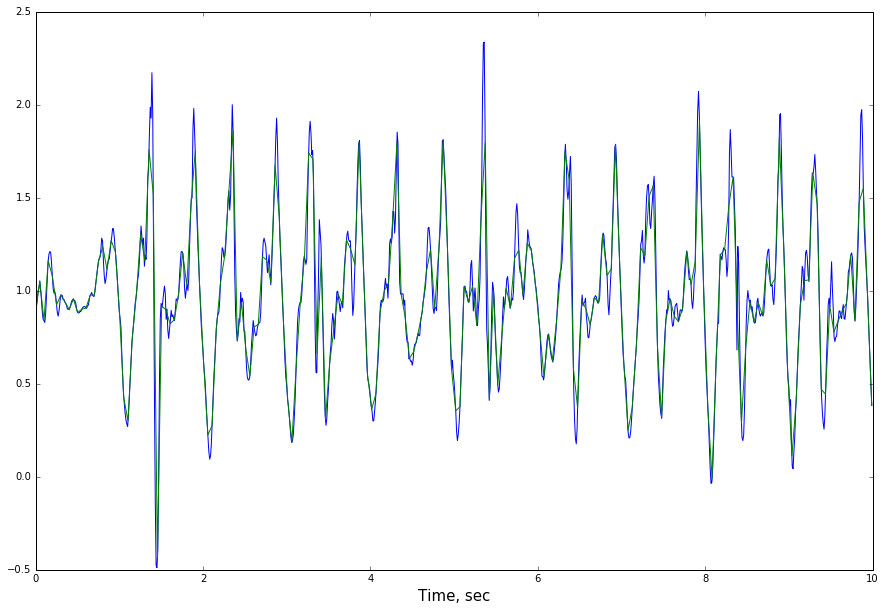

In [2]:
from matplotlib import pylab as plt
%matplotlib inline

x = dataset.ts[200][:, :1000]
t = np.arange(x.shape[1]) / 100

freq = 20
t_, x_ = timeseries.transform_frequency(t, x, freq, kind='linear')

plt.figure(figsize=(15, 10))
plt.plot(t, x[0])
plt.plot(t_, x_[0])
plt.xlabel('Time, sec', size=15)
plt.show()

## Basic Features

In [3]:
X = timeseries.ExtractFeatures(dataset.ts,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: np.sqrt((ts[:3] ** 2).sum(0)).mean(),
    lambda ts: np.hstack([np.histogram(ts_1d, density=True, bins=10)[0] * (ts_1d.max() - ts_1d.min()) / 10 for ts_1d in ts]),
)
X.shape

(840, 79)

....................................................................................................
Mean accuracy: 0.824246031746
Confusion matrix:
 [[ 0.92  0.    0.    0.03  0.03  0.01  0.01  0.    0.    0.    0.    0.  ]
 [ 0.01  0.92  0.01  0.01  0.04  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.89  0.06  0.    0.02  0.02  0.    0.    0.    0.    0.  ]
 [ 0.03  0.02  0.11  0.74  0.07  0.01  0.02  0.    0.    0.    0.    0.  ]
 [ 0.05  0.08  0.    0.06  0.76  0.    0.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.  ]
 [ 0.03  0.    0.    0.02  0.05  0.08  0.82  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.93  0.02  0.01  0.02  0.02]
 [ 0.    0.    0.    0.    0.    0.    0.01  0.03  0.84  0.    0.08  0.04]
 [ 0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.99  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.01  0.03  0.    0.56  0.4 ]
 [ 0.    0.    0.    0.  

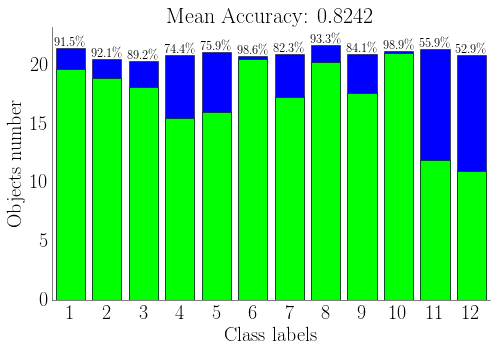

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
  \cline{3-14}
  \multicolumn{2}{c|}{} & \multicolumn{12}{c|}{Predicted class} \\ \cline{3-14}
  \multicolumn{2}{c|}{} & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$ & $11$ & $12$\\ \cline{1-14}
  \multirow{12}{*}{\begin{sideways}Actual class\end{sideways}}
  & $1$ & $0.92$ & $0.00$ & $0.00$ & $0.03$ & $0.03$ & $0.01$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $2$ & $0.01$ & $0.92$ & $0.01$ & $0.01$ & $0.04$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $3$ & $0.00$ & $0.01$ & $0.89$ & $0.06$ & $0.00$ & $0.02$ & $0.02$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $4$ & $0.03$ & $0.02$ & $0.11$ & $0.74$ & $0.07$ & $0.01$ & $0.02$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $5$ & $0.05$ & $0.08$ & $0.00$ & $0.06$ & $0.76$ & $0.00$ & $0.05$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $6$ & $0.00$ & $0.00$ 

In [5]:
from sklearn import svm, cross_validation
from sklearn.multiclass import OneVsRestClassifier

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.002, C=80),
    X, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=100, test_size=0.3, random_state=17),
    fig_name='../../doc/pics/USC-HAD_manual_features_nSplits_100_rate_0.7_OneVsOne_SVM_rbf_c80_g0.002.pdf'
)
multiclass.confusion_latex(confusion_mean)

## Basic Features + AR(6) Parameters

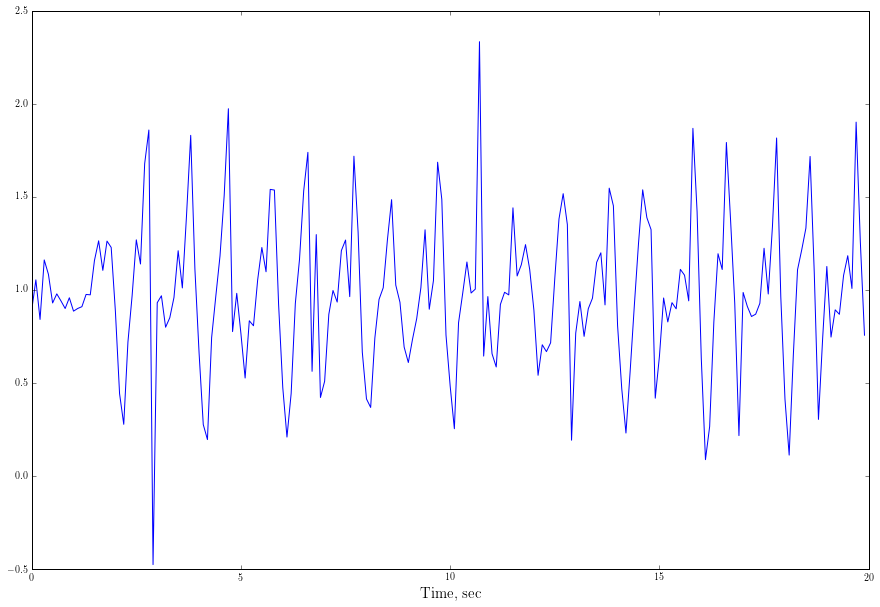

In [10]:
freq = 20

ts_reduced_freq = [
    timeseries.transform_frequency(np.arange(ts.shape[1]) / 100, ts, freq, kind='linear')[1]
    for ts in dataset.ts
]

freq = 10

ts_smoothed = [
    timeseries.smooth(ts, 100 // freq)
    for ts in dataset.ts
]

plt.figure(figsize=(15, 10))
plt.plot(np.arange(200) / freq, ts_reduced_freq[200][0, :200])
plt.xlabel('Time, sec', size=15)
plt.show()

In [11]:
import sklearn

X = timeseries.ExtractFeatures(ts_smoothed,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 11)),
)
X.shape

X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

........................................................................................................................................................................................................
Mean accuracy: 0.931587301587
Confusion matrix:
 [[ 0.93  0.02  0.03  0.02  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.01  0.97  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.03  0.    0.    0.    0.95  0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.01  0.    0.    0.99  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.91  0.07  0.    0.02  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.02  0.96  0.    0.02  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]


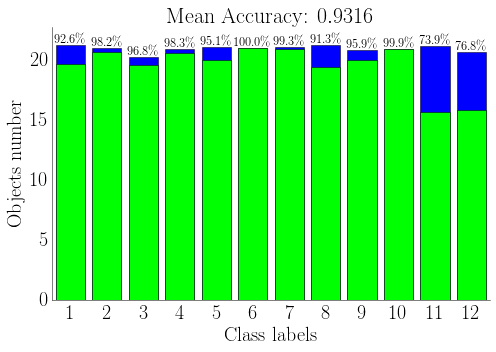

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
  \cline{3-14}
  \multicolumn{2}{c|}{} & \multicolumn{12}{c|}{Predicted class} \\ \cline{3-14}
  \multicolumn{2}{c|}{} & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$ & $11$ & $12$\\ \cline{1-14}
  \multirow{12}{*}{\begin{sideways}Actual class\end{sideways}}
  & $1$ & $0.93$ & $0.02$ & $0.03$ & $0.02$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $2$ & $0.00$ & $0.98$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $3$ & $0.02$ & $0.01$ & $0.97$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $4$ & $0.00$ & $0.00$ & $0.00$ & $0.98$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $5$ & $0.03$ & $0.00$ & $0.00$ & $0.00$ & $0.95$ & $0.02$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $6$ & $0.00$ & $0.00$ 

In [12]:
confusion_mean = multiclass.cross_val_score(
    OneVsRestClassifier(svm.SVC(gamma=0.1, C=16)),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=200, test_size=0.3, random_state=17),
    fig_name='../../doc/pics/USC-HAD_AR10_nSplits_200_rate_0.7_OneVsAll_SVM_rbf_c16_g0.1.pdf'
)
multiclass.confusion_latex(confusion_mean)

## Fourier Transform

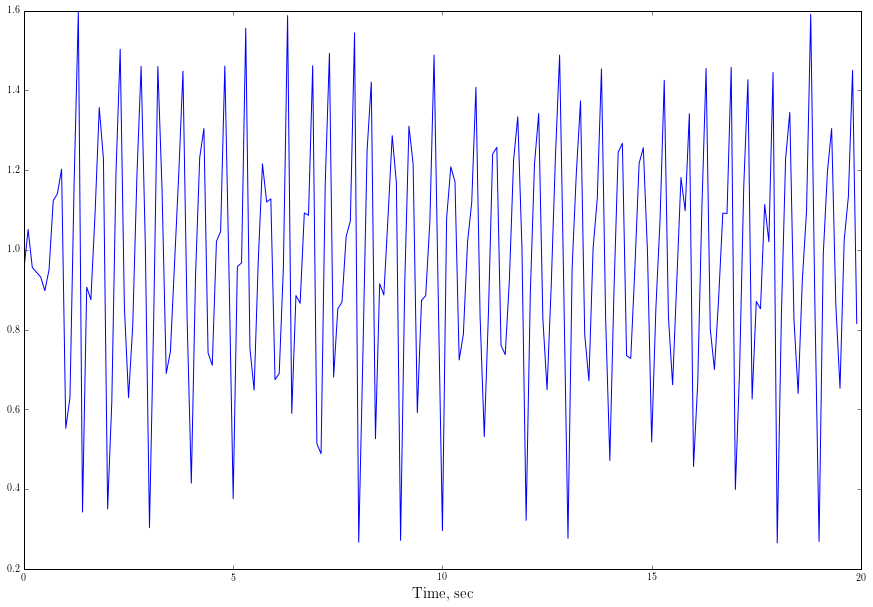

In [13]:
freq = 10

ts_smoothed = [
    timeseries.smooth(ts, 100 // freq)
    for ts in dataset.ts
]

plt.figure(figsize=(15, 10))
plt.plot(np.arange(200) / freq, ts_smoothed[200][0, :200])
plt.xlabel('Time, sec', size=15)
plt.show()

In [14]:
import sklearn.preprocessing

feature_extractors = [
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 5)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 5)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 5)),
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[:3] ** 2).sum(0)), 5)[1:]
]

X = timeseries.ExtractFeatures(ts_smoothed, *feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:   43.1s
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  3.0min finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.981216931217 
Best parameters: {'C': 10.0, 'gamma': 0.12915496650148828}


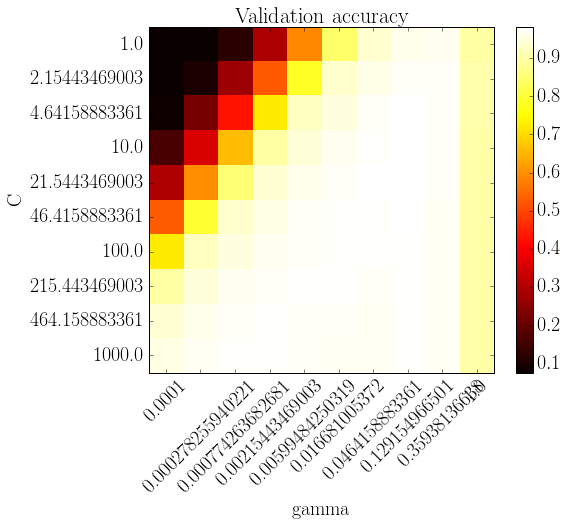

In [147]:
from sklearn.grid_search import GridSearchCV

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(0, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label.size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized, dataset.label)

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Mean accuracy: 0.981825396825
Confusion matrix:
 [[ 0.99  0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.97  0.01  0.    0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.01  0.97  0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]


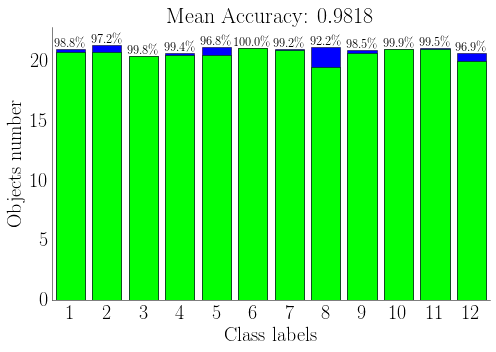

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
  \cline{3-14}
  \multicolumn{2}{c|}{} & \multicolumn{12}{c|}{Predicted class} \\ \cline{3-14}
  \multicolumn{2}{c|}{} & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$ & $11$ & $12$\\ \cline{1-14}
  \multirow{12}{*}{\begin{sideways}Actual class\end{sideways}}
  & $1$ & $0.99$ & $0.00$ & $0.00$ & $0.00$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $2$ & $0.01$ & $0.97$ & $0.01$ & $0.00$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $3$ & $0.00$ & $0.00$ & $1.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $4$ & $0.00$ & $0.00$ & $0.00$ & $0.99$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $5$ & $0.00$ & $0.00$ & $0.00$ & $0.01$ & $0.97$ & $0.02$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $6$ & $0.00$ & $0.00$ 

In [15]:
import multiclass
from sklearn import svm, cross_validation

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.13, C=10),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=500, test_size=0.3, random_state=17),
    fig_name='../../doc/pics/USC-HAD_AR10_nSplits_500_rate_0.7_OneVsOne_SVM_rbf_c10_g0.13.pdf'
)
multiclass.confusion_latex(confusion_mean)

## Distribution

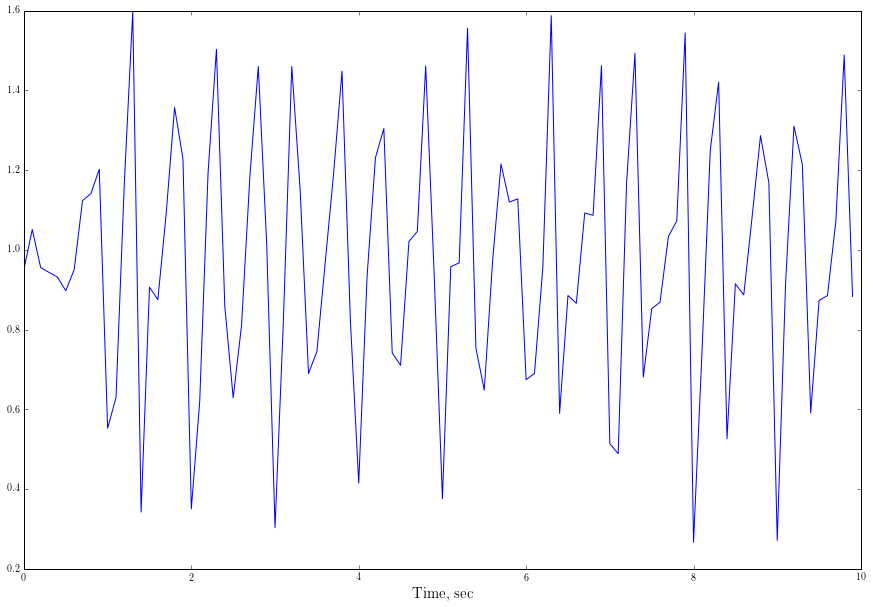

In [16]:
freq = 10

ts_smoothed = [
    timeseries.smooth(ts, 100 // freq)
    for ts in dataset.ts
]

plt.figure(figsize=(15, 10))
plt.plot(np.arange(10 * freq) / freq, ts_smoothed[200][0, :10 * freq])
plt.xlabel('Time, sec', size=15)
plt.show()

In [17]:
print("Stats:\n", pandas.DataFrame([ts.shape for ts in ts_smoothed],
                                   columns=['dim', 'len']).describe()[1:].round())

Stats:
       dim   len
mean    6   335
std     0   198
min     6    60
25%     6   200
50%     6   300
75%     6   450
max     6  1350


In [18]:
import itertools
import sklearn.preprocessing


def split_dataset(dataset_ts, chunk_size):
    chunks, indices = [], []

    for index, ts in enumerate(dataset_ts):
        ts = np.atleast_2d(ts)
        try:
            splitted = np.hsplit(ts[:, :ts.shape[1] - ts.shape[1] % chunk_size],
                                 ts.shape[1] // chunk_size)
        except:
            splitted = [ts]
        chunks.extend(splitted)
        indices.extend([index] * len(splitted))

    return chunks, indices


def hyperparams_transform(dataset_ts, chunk_size, feature_extractors):
    chunks, indices = split_dataset(dataset_ts, chunk_size)

    X = timeseries.ExtractFeatures(chunks, *feature_extractors)

    G, X_ = [], []

    for k, g in itertools.groupby(zip(X, indices), lambda pair: pair[1]):
        G.append(list(zip(*g))[0])
        X_.append(np.hstack((np.mean(G[-1], 0), np.std(G[-1], 0, ddof=0))))
    return np.vstack(X_)

In [17]:
accuracy = []

chunk_size_space = np.linspace(15, 600, 100).astype(int)

for chunk_size in chunk_size_space:
    X = hyperparams_transform(ts_smoothed, chunk_size, feature_extractors)
    X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
    confusion_mean = multiclass.cross_val_score(
        svm.SVC(kernel='linear', C=1),
        X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10],
        cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=100, test_size=0.3, random_state=17),
        output=False
    )
    accuracy.append(np.diag(confusion_mean).sum() / confusion_mean.sum())
accuracy

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.96161904761904771,
 0.96904761904761905,
 0.96990476190476194,
 0.96966666666666668,
 0.97252380952380946,
 0.96819047619047627,
 0.97523809523809546,
 0.9729523809523809,
 0.9729523809523809,
 0.96947619047619049,
 0.97142857142857153,
 0.97485714285714287,
 0.96347619047619049,
 0.96219047619047615,
 0.96438095238095234,
 0.95957142857142863,
 0.96247619047619037,
 0.96638095238095245,
 0.96919047619047616,
 0.95895238095238089,
 0.95976190476190482,
 0.96090476190476182,
 0.96433333333333338,
 0.96561904761904749,
 0.96409523809523801,
 0.96195238095238123,
 0.9584285714285713,
 0.95709523809523811,
 0.95771428571428574,
 0.95857142857142863,
 0.95938095238095233,
 0.96138095238095245,
 0.96099999999999997,
 0.95800000000000007,
 0.95723809523809511,
 0.96100000000000019,
 0.9582857142857143,
 0.95976190476190482,
 0.96061904761904771,
 0.95990476190476182,
 0.97004761904761905,
 0.96871428571428564,
 0.96757142857142853,
 0.9646190476190476,
 0.9658095238095239,
 0.9681904761904

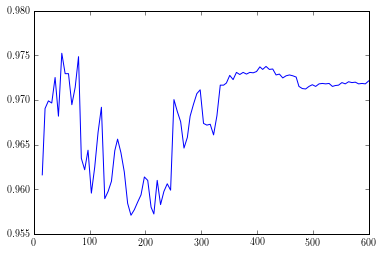

In [18]:
plt.plot(chunk_size_space, accuracy)
plt.show()

In [19]:
chunk_size_space[np.argmax(accuracy)]

50

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:   44.0s
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:  4.3min remaining:    0.1s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  4.3min finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.981746031746 
Best parameters: {'C': 77.426368268112697, 'gamma': 0.016681005372000592}


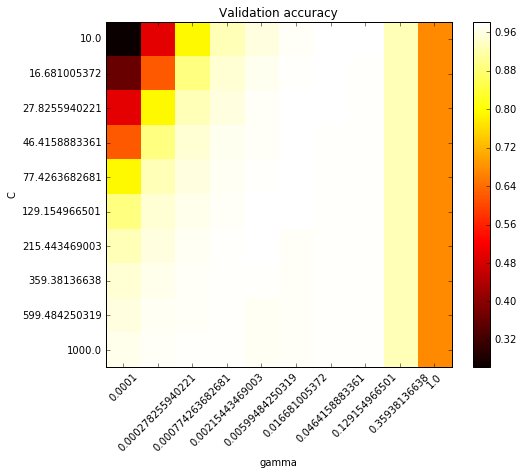

In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn import svm, cross_validation

X = hyperparams_transform(ts_smoothed, 50, feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(1, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10])

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:   38.6s
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  3.5min finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.978888888889 
Best parameters: {'C': 10.0, 'gamma': 0.12915496650148828}


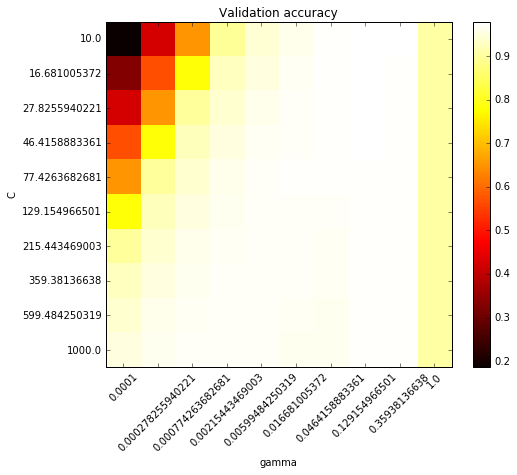

In [13]:
from sklearn.grid_search import GridSearchCV

X = hyperparams_transform(ts_smoothed, 2000, feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(1, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10])

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:   41.8s
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:  4.2min remaining:    0.1s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  4.2min finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.975555555556 
Best parameters: {'C': 16.681005372000591, 'gamma': 0.046415888336127774}


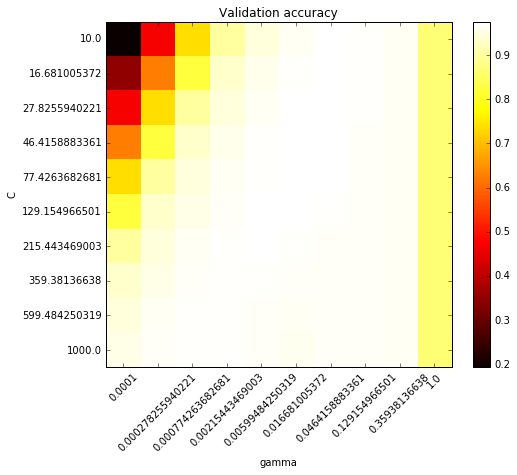

In [14]:
from sklearn.grid_search import GridSearchCV

X = hyperparams_transform(ts_smoothed, 400, feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(1, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10])

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

In [15]:
class VotingSVM(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, X, indices, svm):
        self.X = X
        self.indices = np.array(indices)
        self.svm = svm

    def fit(self, observations, y):
        idx = np.array([i in observations for i in self.indices])
        labels = np.zeros(idx.sum())
        for i, c in zip(observations, y):
            labels[self.indices[idx] == i] = c

        self.svm = self.svm.fit(self.X[idx], labels)
        return self

    def predict(self, observations):
        idx = np.array([i in observations for i in self.indices])
        predicted_labels = self.svm.predict(self.X[idx])

        labels = []
        for k, g in itertools.groupby(zip(predicted_labels, self.indices[idx]), lambda pair: pair[1]):
            G = list(zip(*g))[0]
            labels.append(int(scipy.stats.mode(G[-1])[0]))

        result = np.zeros(len(labels))
        result[np.argsort(observations)] = np.hstack(labels)
        return result

    def score(self, observations, y):
        y_estimation = self.predict(observations)
        return sklearn.metrics.accuracy_score(y, y_estimation)

In [17]:
import scipy

voting_accuracy = []

chunk_size_space = np.linspace(15, 600, 100).astype(int)

for chunk_size in chunk_size_space:
    chunks, indices = split_dataset(ts_smoothed, chunk_size)
    X = timeseries.ExtractFeatures(chunks, *feature_extractors)
    X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

    confusion_mean = multiclass.cross_val_score(
        VotingSVM(X_normalized, indices, svm.SVC(**{'C': 100.0, 'gamma': 0.017})),
        np.arange(len(ts_smoothed))[dataset.label <= 10], dataset.label[dataset.label <= 10],
        cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=100, test_size=0.3, random_state=17),
        output=False
    )
    voting_accuracy.append(np.diag(confusion_mean).sum() / confusion_mean.sum())
voting_accuracy

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.80428571428571427,
 0.85323809523809524,
 0.92900000000000005,
 0.94071428571428573,
 0.94552380952380943,
 0.95114285714285696,
 0.96219047619047615,
 0.96300000000000008,
 0.97071428571428586,
 0.97061904761904783,
 0.96942857142857153,
 0.9701428571428572,
 0.97719047619047628,
 0.97328571428571431,
 0.97623809523809535,
 0.97171428571428564,
 0.97600000000000009,
 0.97766666666666691,
 0.97547619047619061,
 0.9728095238095239,
 0.97061904761904783,
 0.97442857142857142,
 0.97623809523809535,
 0.97519047619047616,
 0.97471428571428576,
 0.97357142857142864,
 0.97114285714285731,
 0.97109523809523812,
 0.97061904761904749,
 0.9718095238095239,
 0.9730952380952379,
 0.97561904761904761,
 0.97257142857142853,
 0.97133333333333338,
 0.97104761904761916,
 0.97080952380952379,
 0.97171428571428575,
 0.97109523809523823,
 0.97080952380952379,
 0.97090476190476194,
 0.97457142857142853,
 0.97333333333333349,
 0.97166666666666668,
 0.9696190476190476,
 0.97166666666666657,
 0.972904761904

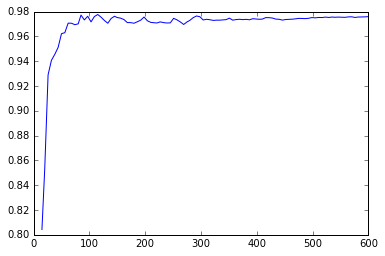

In [18]:
plt.plot(chunk_size_space, voting_accuracy)
plt.show()

In [19]:
accuracy = []

chunk_size_space = np.linspace(15, 600, 100).astype(int)

for chunk_size in chunk_size_space:
    X = hyperparams_transform(ts_smoothed, chunk_size, feature_extractors)
    X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
    confusion_mean = multiclass.cross_val_score(
        svm.SVC(**{'C': 100.0, 'gamma': 0.017}),
        X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10],
        cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=100, test_size=0.3, random_state=17),
        output=False
    )
    accuracy.append(np.diag(confusion_mean).sum() / confusion_mean.sum())
accuracy

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.9652857142857143,
 0.97209523809523835,
 0.97142857142857142,
 0.97971428571428576,
 0.97538095238095246,
 0.97838095238095246,
 0.98161904761904772,
 0.98100000000000009,
 0.98023809523809524,
 0.97404761904761905,
 0.97590476190476194,
 0.97838095238095246,
 0.9686190476190476,
 0.96923809523809534,
 0.97223809523809535,
 0.96380952380952367,
 0.96490476190476193,
 0.96947619047619049,
 0.97309523809523824,
 0.96314285714285708,
 0.96628571428571419,
 0.961095238095238,
 0.96900000000000019,
 0.96980952380952379,
 0.97128571428571442,
 0.96809523809523812,
 0.96323809523809523,
 0.96471428571428575,
 0.96361904761904771,
 0.96261904761904749,
 0.95900000000000019,
 0.96566666666666667,
 0.96314285714285708,
 0.96095238095238089,
 0.95976190476190482,
 0.96276190476190482,
 0.96533333333333338,
 0.96109523809523834,
 0.9646190476190476,
 0.9632857142857143,
 0.96999999999999997,
 0.96985714285714297,
 0.96799999999999986,
 0.96414285714285719,
 0.96623809523809534,
 0.9671904761904

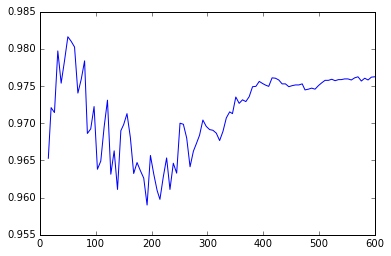

In [20]:
plt.plot(chunk_size_space, accuracy)
plt.show()

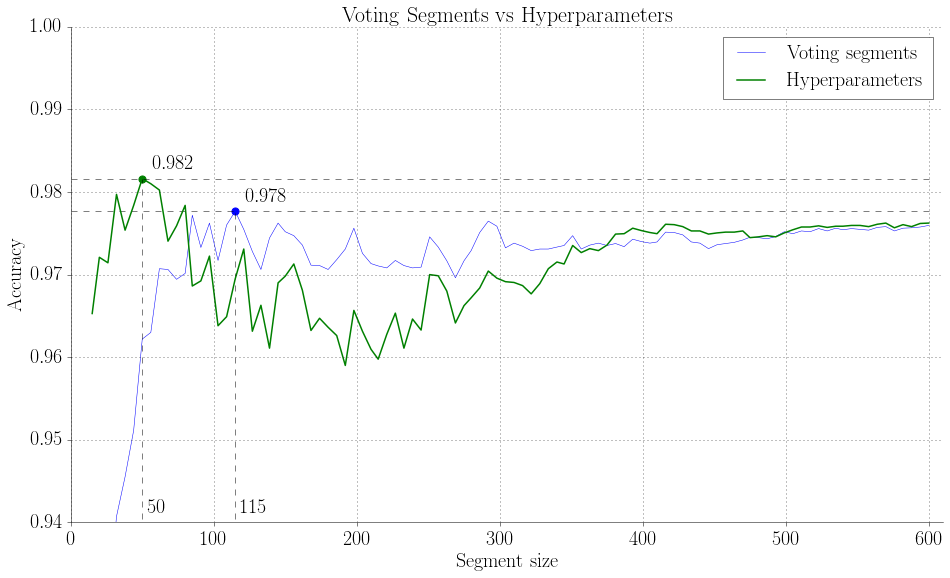

In [133]:
fig_width = 3.39 * 4

golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches

plt.figure(figsize=(fig_width, fig_height))
ax = plt.subplot(111)

params = {
    'backend': 'ps',
    'axes.labelsize': 20, # fontsize for x and y labels (was 10)
    'axes.titlesize': 22,
    'font.size': 20, # was 10
    'legend.fontsize': 20, # was 10
    'text.usetex': True,
    'figure.figsize': [fig_width, fig_height],
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'pgf.texsystem': 'pdflatex'
}

plt.rcParams.update(params)

plt.plot(chunk_size_space, voting_accuracy, label='Voting segments', linewidth=0.5)
x, y = chunk_size_space[np.argmax(voting_accuracy)], voting_accuracy[np.argmax(voting_accuracy)]
plt.plot([x, x], [0, y], color='black', linewidth=0.5, linestyle="--")
plt.plot([0, 600], [y, y], color='black', linewidth=0.5, linestyle="--")
plt.scatter([x, ], [y, ], 50, color='blue')
plt.annotate('${:.3f}$'.format(y),
             xy=(x, y), xycoords='data',
             xytext=(+10, +10), textcoords='offset points', fontsize=20)
plt.annotate('${}$'.format(x),
             xy=(x, 0.94), xycoords='data',
             xytext=(+5, +10), textcoords='offset points', fontsize=20)

plt.plot(chunk_size_space, accuracy, label='Hyperparameters', linewidth=1.5)
x, y = chunk_size_space[np.argmax(accuracy)], accuracy[np.argmax(accuracy)]
plt.plot([x, x], [0, y], color='black', linewidth=0.5, linestyle="--")
plt.plot([0, 600], [y, y], color='black', linewidth=0.5, linestyle="--")
plt.scatter([x, ], [y, ], 50, color='green')
plt.annotate('${:.3f}$'.format(y),
             xy=(x, y), xycoords='data',
             xytext=(+10, +10), textcoords='offset points', fontsize=20)
plt.annotate('${}$'.format(x),
             xy=(x, 0.94), xycoords='data',
             xytext=(+5, +10), textcoords='offset points', fontsize=20)


plt.ylim([0.94, 1])
plt.xlim([0, 610])
plt.xlabel('Segment size', size=20)
plt.ylabel('Accuracy', size=20)
plt.title('Voting Segments vs Hyperparameters')
plt.tight_layout()
plt.legend(loc='best')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_tick_params(direction='out')

frame = ax.legend().get_frame().set_linewidth(0.5)
plt.grid()

plt.savefig('voting_vs_normal.pdf')
plt.show()

In [21]:
chunk_size_space[np.argmax(accuracy)]

50

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:   51.4s
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:  4.8min remaining:    0.1s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  4.8min finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.981746031746 
Best parameters: {'C': 77.426368268112697, 'gamma': 0.016681005372000592}


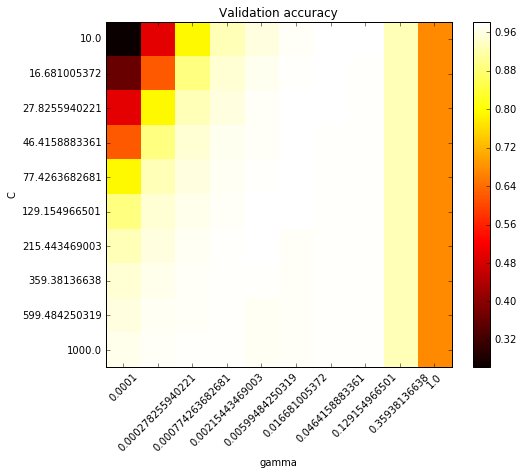

In [22]:
from sklearn.grid_search import GridSearchCV

X = hyperparams_transform(ts_smoothed, chunk_size_space[np.argmax(accuracy)], feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(1, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10])

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

....................................................................................................
Mean accuracy: 0.981619047619
Confusion matrix:
 [[ 0.99  0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.98  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.  ]
 [ 0.01  0.01  0.    0.    0.98  0.01  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.93  0.07  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.03  0.97  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]


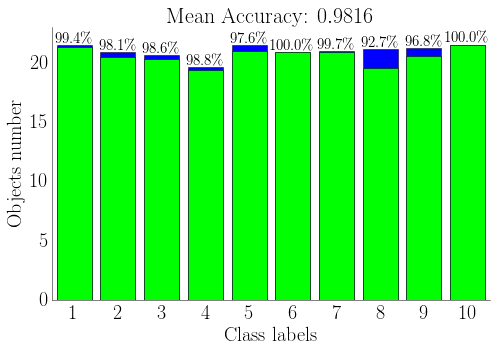

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|}
  \cline{3-12}
  \multicolumn{2}{c|}{} & \multicolumn{10}{c|}{Predicted class} \\ \cline{3-12}
  \multicolumn{2}{c|}{} & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$\\ \cline{1-12}
  \multirow{10}{*}{\begin{sideways}Actual class\end{sideways}}
  & $1$ & $0.99$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-12}
  & $2$ & $0.01$ & $0.98$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-12}
  & $3$ & $0.01$ & $0.00$ & $0.99$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-12}
  & $4$ & $0.00$ & $0.00$ & $0.00$ & $0.99$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-12}
  & $5$ & $0.01$ & $0.01$ & $0.00$ & $0.00$ & $0.98$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-12}
  & $6$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $1.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-12}
  & $7$ & $0.00$ & $0

In [19]:
X = hyperparams_transform(ts_smoothed, 50, feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
confusion_mean = multiclass.cross_val_score(
    svm.SVC(**{'C': 100.0, 'gamma': 0.017}),
    X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10],
    cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=100, test_size=0.3, random_state=17),
    fig_name='../../doc/pics/USC-HAD_1-10_segment-len-50_nSplits_100_rate_0.7_OneVsOne_SVM_rbf_c100_g0.017.pdf'
)
multiclass.confusion_latex(confusion_mean)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Mean accuracy: 0.98226984127
Confusion matrix:
 [[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.99  0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.01  0.    0.    0.97  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 

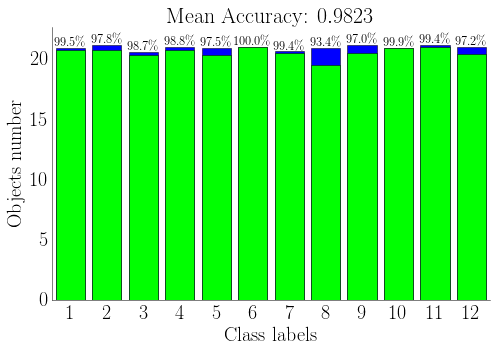

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
  \cline{3-14}
  \multicolumn{2}{c|}{} & \multicolumn{12}{c|}{Predicted class} \\ \cline{3-14}
  \multicolumn{2}{c|}{} & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$ & $11$ & $12$\\ \cline{1-14}
  \multirow{12}{*}{\begin{sideways}Actual class\end{sideways}}
  & $1$ & $1.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $2$ & $0.01$ & $0.98$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $3$ & $0.00$ & $0.00$ & $0.99$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $4$ & $0.00$ & $0.00$ & $0.00$ & $0.99$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $5$ & $0.01$ & $0.01$ & $0.00$ & $0.00$ & $0.97$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $6$ & $0.00$ & $0.00$ 

In [22]:
X_hyper = hyperparams_transform(ts_smoothed, 50, feature_extractors)
X_hyper_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_hyper)

X = timeseries.ExtractFeatures(ts_smoothed, *feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

class MyClassifier(sklearn.base.ClassifierMixin, sklearn.base.BaseEstimator):
    def fit(self, observations, y):
        new_y = y.copy()
        new_y[y <= 10] = 0
        observations = np.array(observations)
        self.estimator = svm.SVC(gamma=0.13, C=10).fit(X_normalized[observations], new_y)
        self.classifier = svm.SVC(**{'C': 100.0, 'gamma': 0.017}).fit(X_hyper_normalized[observations[y <= 10]], y[y <= 10])
        return self

    def predict(self, observations):
        y_estimation = self.estimator.predict(X_normalized[observations])
        y_estimation[y_estimation == 0] = self.classifier.predict(X_hyper_normalized[observations[y_estimation == 0]])
        return y_estimation

    def score(self, observations, y):
        y_estimation = self.predict(observations)
        return sklearn.metrics.accuracy_score(y, y_estimation)


confusion_mean = multiclass.cross_val_score(
    MyClassifier(),
    np.arange(len(ts_smoothed)), dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=500, test_size=0.3, random_state=48),
    fig_name='../../doc/pics/USC-HAD_segment-len-50_nSplits_500_rate_0.7_OneVsOne_SVM_rbf_c100_g0.017.pdf'
)
multiclass.confusion_latex(confusion_mean)

In [57]:
def random_split_dataset(dataset_ts, chunk_size, num_chunks):
    chunks, indices = [], []

    for index, ts in enumerate(dataset_ts):
        ts = np.atleast_2d(ts)
        try:
            begin_pos = np.random.choice(np.arange(ts.shape[1] - chunk_size + 1), num_chunks, replace=True)
            splitted = np.lib.stride_tricks.as_strided(ts, (ts.shape[1] - chunk_size + 1, ts.shape[0], chunk_size),
                                                           (ts.strides[1], ts.strides[0], ts.strides[1])
                                                      )[begin_pos]
        except:
            splitted = ts[np.newaxis]
        chunks.extend(list(splitted))
        indices.extend([index] * len(splitted))

    return chunks, indices


def random_hyperparams_transform(dataset_ts, chunk_size, num_chunks, feature_extractors):
    chunks, indices = random_split_dataset(dataset_ts, chunk_size, num_chunks)

    X = timeseries.ExtractFeatures(chunks, *feature_extractors)

    G, X_ = [], []

    for k, g in itertools.groupby(zip(X, indices), lambda pair: pair[1]):
        G.append(list(zip(*g))[0])
        X_.append(np.hstack((np.mean(G[-1], 0), np.std(G[-1], 0, ddof=1))))
    return np.vstack(X_)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Mean accuracy: 0.980611111111
Confusion matrix:
 [[ 0.99  0.    0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.    0.01  0.97  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]


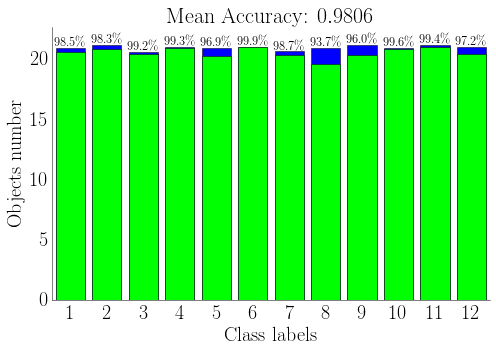

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
  \cline{3-14}
  \multicolumn{2}{c|}{} & \multicolumn{12}{c|}{Predicted class} \\ \cline{3-14}
  \multicolumn{2}{c|}{} & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$ & $11$ & $12$\\ \cline{1-14}
  \multirow{12}{*}{\begin{sideways}Actual class\end{sideways}}
  & $1$ & $0.99$ & $0.00$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $2$ & $0.00$ & $0.98$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $3$ & $0.01$ & $0.00$ & $0.99$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $4$ & $0.00$ & $0.00$ & $0.00$ & $0.99$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $5$ & $0.01$ & $0.00$ & $0.00$ & $0.01$ & $0.97$ & $0.01$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$\\ \cline{2-14}
  & $6$ & $0.00$ & $0.00$ 

In [66]:
X_hyper = random_hyperparams_transform(ts_smoothed, 50, 100, feature_extractors)
X_hyper_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_hyper)
X = timeseries.ExtractFeatures(ts_smoothed, *feature_extractors)
X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

class MyClassifier(sklearn.base.ClassifierMixin, sklearn.base.BaseEstimator):
    def fit(self, observations, y):
        new_y = y.copy()
        new_y[y <= 10] = 0
        observations = np.array(observations)
        self.estimator = svm.SVC(gamma=0.13, C=10).fit(X_normalized[observations], new_y)
        self.classifier = svm.SVC(**{'C': 100.0, 'gamma': 0.017}).fit(X_hyper_normalized[observations[y <= 10]], y[y <= 10])
        return self

    def predict(self, observations):
        y_estimation = self.estimator.predict(X_normalized[observations])
        y_estimation[y_estimation == 0] = self.classifier.predict(X_hyper_normalized[observations[y_estimation == 0]])
        return y_estimation

    def score(self, observations, y):
        y_estimation = self.predict(observations)
        return sklearn.metrics.accuracy_score(y, y_estimation)


confusion_mean = multiclass.cross_val_score(
    MyClassifier(),
    np.arange(len(ts_smoothed)), dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=500, test_size=0.3, random_state=48),
    fig_name='../../doc/pics/USC-HAD_segment-random-len-50_nSplits_500_rate_0.7_OneVsOne_SVM_rbf_c100_g0.017.pdf'
)
multiclass.confusion_latex(confusion_mean)